<a href="https://colab.research.google.com/github/earltreloar/logosfield-cddr-analysis/blob/main/SMBH_DeltaT_Colab_Repro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

No CSV found — using built-in fallback (4 quasars).


,id,z,MBH_Msun,eps,t_form_LCDM_Gyr,t_obs_LCDM_Gyr,dt_LCDM_Gyr,t_form_Logos_Gyr,t_obs_Logos_Gyr,dt_Logos_Gyr,Mseed_planck,Mseed_logos,ok_planck_seed<=1e+06,ok_logos_seed<=1e+06,min_duty_for_seed1e5_LCDM,min_duty_for_seed1e5_Logos,min_lambda_for_seed1e5_LCDM,min_lambda_for_seed1e5_Logos
0,J0313-1806,7.64,1.600000e+09,0.1,0.26,0.886,0.626,0.312,1.063,0.751,5.845e+03,4.778e+02,True,True,0.77,0.64,0.01,0.01
1,J1342+0928,7.54,8.000000e+08,0.1,0.26,0.896,0.636,0.312,1.075,0.763,2.393e+03,1.879e+02,True,True,0.71,0.59,0.01,0.01
2,J1007+2115,7.52,1.500000e+09,0.1,0.26,0.898,0.638,0.312,1.078,0.766,4.310e+03,3.359e+02,True,True,0.75,0.63,0.01,0.01
3,J1120+0641,7.10,2.000000e+09,0.1,0.26,0.940,0.680,0.312,1.128,0.816,2.481e+03,1.634e+02,True,True,0.73,0.61,0.01,0.01


Wrote /content/smbh_growth_results_DELTAT.csv


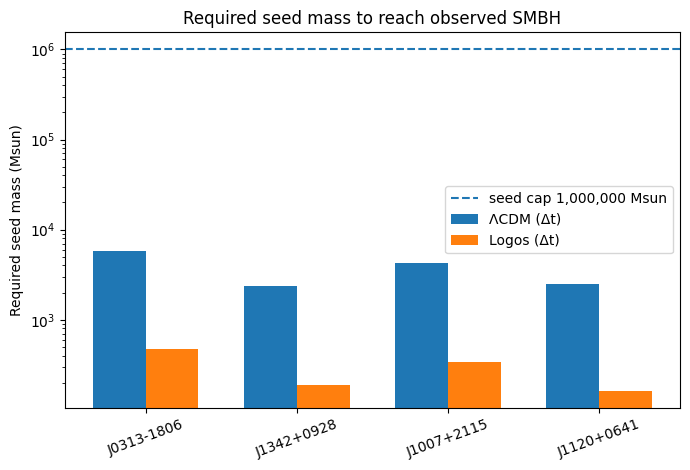

Wrote /content/smbh_required_seed_bar_DELTAT.png


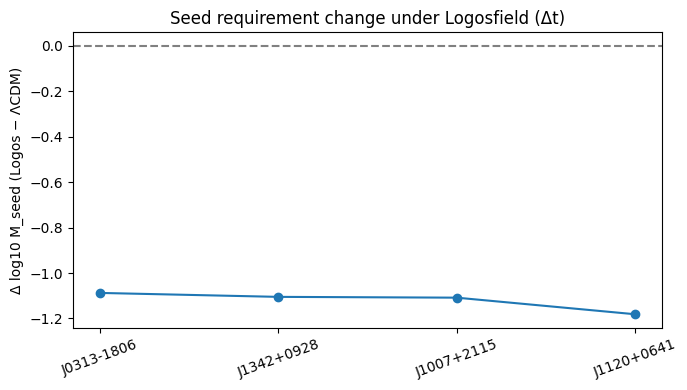

Wrote /content/smbh_seed_delta_log10_DELTAT.png

Files written:
 /content/smbh_growth_results_DELTAT.csv
 /content/smbh_required_seed_bar_DELTAT.png
 /content/smbh_seed_delta_log10_DELTAT.png


In [1]:
# SMBH growth feasibility — one-cell runner (ΛCDM vs Logosfield, FIXED with Δt)
# Paste this ENTIRE cell into a fresh Colab notebook and Run.

import os, pandas as pd, numpy as np, matplotlib.pyplot as plt

# ---------- Input options ----------
# If you have a CSV, upload it as /content/smbh_quasars_savedes.csv
# Columns: id,z,MBH_Msun[,eps]
CSV_LOCAL = "/content/smbh_quasars_savedes.csv"
CSV_URL   = os.environ.get("SMBH_CSV_URL","").strip()  # optional raw CSV URL

def load_quasar_table():
    if os.path.exists(CSV_LOCAL):
        print(f"Loaded local CSV: {CSV_LOCAL}")
        return pd.read_csv(CSV_LOCAL)
    if CSV_URL:
        try:
            df = pd.read_csv(CSV_URL)
            print(f"Loaded CSV from URL: {CSV_URL}")
            return df
        except Exception as e:
            print("URL fetch failed:", e)
    print("No CSV found — using built-in fallback (4 quasars).")
    return pd.DataFrame([
        {"id":"J1120+0641","z":7.10,"MBH_Msun":2.0e9},
        {"id":"J1342+0928","z":7.54,"MBH_Msun":8.0e8},
        {"id":"J0313-1806","z":7.64,"MBH_Msun":1.6e9},
        {"id":"J1007+2115","z":7.52,"MBH_Msun":1.5e9},
    ])

dfq = load_quasar_table()

# ---------- Tunables ----------
epsilon_default = 0.10   # radiative efficiency if 'eps' missing
duty_target     = 1.00   # duty used for seed-mass calc
lambda_target   = 1.00   # Eddington ratio used for seed-mass calc
logos_scale     = 1.20   # Logosfield effective extra growth-time factor
seed_cap        = 1e6    # threshold to flag "acceptable" seed (Msun)
z_form_guess    = 25.0   # seeding redshift used to get Δt = t(zobs)-t(zform)

# ---------- Correct age(z) (Planck-like LCDM), extended to z=30 ----------
def age_planck_Gyr(z: float) -> float:
    # z ascending; age descending; coarse but adequate at high-z
    Z = np.array([ 0.0,  0.5,  1.0,  2.0,  3.0,  4.0,  5.0,  6.0,  7.0,  8.0,  9.0, 10.0, 15.0, 20.0, 25.0, 30.0])
    T = np.array([13.8,  8.6,  5.9,  3.3,  2.2,  1.6,  1.3,  1.1,  0.95, 0.85, 0.78, 0.72, 0.47, 0.34, 0.26, 0.21])
    zc = float(np.clip(z, Z.min(), Z.max()))
    return float(np.interp(zc, Z, T))

def age_logos_Gyr(z: float, scale: float = 1.20) -> float:
    return scale * age_planck_Gyr(z)

# ---------- Accretion relations ----------
def t_salpeter_Gyr(eps: float, lam: float = 1.0) -> float:
    # t_S ≈ 0.45 Gyr * [ε/(1−ε)] * (1/λ)
    return 0.45 * (eps / max(1e-6, 1.0 - eps)) / max(1e-6, lam)

def seed_required(Mf: float, dt_Gyr: float, eps: float, duty: float = 1.0, lam: float = 1.0) -> float:
    # Mf = Ms * exp( (duty*dt)/tS )  => Ms = Mf * exp( -(duty*dt)/tS )
    tS = t_salpeter_Gyr(eps, lam)
    return float(Mf * np.exp(-(duty * dt_Gyr)/max(1e-9, tS)))

def min_duty_for_seed(Ms: float, Mf: float, dt_Gyr: float, eps: float, lam: float = 1.0) -> float:
    # duty = (tS/dt) * ln(Mf/Ms)
    if dt_Gyr <= 0 or Mf <= Ms: return 0.0
    tS = t_salpeter_Gyr(eps, lam)
    return float((tS / dt_Gyr) * np.log(Mf / Ms))

def min_lambda_for_seed(Ms: float, Mf: float, dt_Gyr: float, eps: float, duty: float = 1.0) -> float:
    # λ = [0.45 * ε/(1−ε)] * [duty / dt] / ln(Mf/Ms)
    if dt_Gyr <= 0 or Mf <= Ms: return 0.0
    A = 0.45 * (eps / max(1e-6, 1.0 - eps))
    return float( A * (duty / max(1e-9, dt_Gyr)) / max(1e-9, np.log(Mf / Ms)) )

# ---------- Compute using Δt = t(zobs) - t(zform) ----------
t_form_LCDM  = age_planck_Gyr(z_form_guess)
t_form_Logos = age_logos_Gyr(z_form_guess, logos_scale)

rows = []
for i, r in dfq.iterrows():
    z   = float(r["z"])
    MBH = float(r["MBH_Msun"])
    _id = str(r.get("id", f"obj_{i}"))
    eps = float(r.get("eps", epsilon_default))

    t_obs_LCDM  = age_planck_Gyr(z)
    t_obs_Logos = age_logos_Gyr(z, logos_scale)

    dt_LCDM  = max(0.0, t_obs_LCDM  - t_form_LCDM)
    dt_Logos = max(0.0, t_obs_Logos - t_form_Logos)

    Mseed_P = seed_required(MBH, dt_LCDM,  eps, duty_target, lambda_target)
    Mseed_L = seed_required(MBH, dt_Logos, eps, duty_target, lambda_target)

    seed_test = 1e5
    duty_min_P = min_duty_for_seed(seed_test, MBH, dt_LCDM,  eps, lambda_target)
    duty_min_L = min_duty_for_seed(seed_test, MBH, dt_Logos, eps, lambda_target)
    lam_min_P  = min_lambda_for_seed(seed_test, MBH, dt_LCDM,  eps, duty_target)
    lam_min_L  = min_lambda_for_seed(seed_test, MBH, dt_Logos, eps, duty_target)

    rows.append({
        "id": _id, "z": z, "MBH_Msun": MBH, "eps": eps,
        "t_form_LCDM_Gyr": round(t_form_LCDM,3), "t_obs_LCDM_Gyr": round(t_obs_LCDM,3), "dt_LCDM_Gyr": round(dt_LCDM,3),
        "t_form_Logos_Gyr": round(t_form_Logos,3), "t_obs_Logos_Gyr": round(t_obs_Logos,3), "dt_Logos_Gyr": round(dt_Logos,3),
        "Mseed_planck": Mseed_P, "Mseed_logos": Mseed_L,
        f"ok_planck_seed<={seed_cap:.0e}": Mseed_P <= seed_cap,
        f"ok_logos_seed<={seed_cap:.0e}":  Mseed_L <= seed_cap,
        "min_duty_for_seed1e5_LCDM": duty_min_P,
        "min_duty_for_seed1e5_Logos": duty_min_L,
        "min_lambda_for_seed1e5_LCDM": lam_min_P,
        "min_lambda_for_seed1e5_Logos": lam_min_L
    })

out = pd.DataFrame(rows).sort_values("z", ascending=False).reset_index(drop=True)

# Display tidy view
display(out.assign(
    Mseed_planck=lambda d: d["Mseed_planck"].map(lambda v: f"{v:.3e}"),
    Mseed_logos =lambda d: d["Mseed_logos"].map(lambda v: f"{v:.3e}"),
    min_duty_for_seed1e5_LCDM =lambda d: d["min_duty_for_seed1e5_LCDM"].map(lambda v: f"{v:.2f}"),
    min_duty_for_seed1e5_Logos=lambda d: d["min_duty_for_seed1e5_Logos"].map(lambda v: f"{v:.2f}"),
    min_lambda_for_seed1e5_LCDM=lambda d: d["min_lambda_for_seed1e5_LCDM"].map(lambda v: f"{v:.2f}"),
    min_lambda_for_seed1e5_Logos=lambda d: d["min_lambda_for_seed1e5_Logos"].map(lambda v: f"{v:.2f}"),
))

# Save CSV
csv_out = "/content/smbh_growth_results_DELTAT.csv"
out.to_csv(csv_out, index=False)
print("Wrote", csv_out)

# ---------- Plots ----------
def barplot_seed(df, outpng):
    labels = df["id"].tolist()
    x = np.arange(len(labels)); w = 0.35
    P = df["Mseed_planck"].values
    L = df["Mseed_logos"].values

    plt.figure(figsize=(max(7, 1.4*len(labels)), 4.8))
    plt.bar(x - w/2, P, width=w, label="ΛCDM (Δt)", align="center")
    plt.bar(x + w/2, L, width=w, label="Logos (Δt)", align="center")
    plt.axhline(seed_cap, ls="--", label=f"seed cap {int(seed_cap):,} Msun")
    plt.yscale("log")
    plt.xticks(x, labels, rotation=20)
    plt.ylabel("Required seed mass (Msun)")
    plt.title("Required seed mass to reach observed SMBH")
    plt.legend()
    plt.tight_layout()
    plt.savefig(outpng, dpi=160)
    plt.show()
    print("Wrote", outpng)

def lineplot_delta(df, outpng):
    labels = df["id"].tolist()
    x = np.arange(len(labels))
    dlog = np.log10(df["Mseed_logos"].values) - np.log10(df["Mseed_planck"].values)

    plt.figure(figsize=(max(7, 1.4*len(labels)), 4.0))
    plt.plot(x, dlog, 'o-')
    plt.axhline(0, color='gray', ls='--')
    plt.xticks(x, labels, rotation=20)
    plt.ylabel("Δ log10 M_seed (Logos − ΛCDM)")
    plt.title("Seed requirement change under Logosfield (Δt)")
    plt.tight_layout()
    plt.savefig(outpng, dpi=160)
    plt.show()
    print("Wrote", outpng)

barplot_seed(out, "/content/smbh_required_seed_bar_DELTAT.png")
lineplot_delta(out, "/content/smbh_seed_delta_log10_DELTAT.png")

print("\nFiles written:\n",
      "/content/smbh_growth_results_DELTAT.csv\n",
      "/content/smbh_required_seed_bar_DELTAT.png\n",
      "/content/smbh_seed_delta_log10_DELTAT.png")
